In [35]:
%matplotlib inline
import requests
from datetime import datetime
from matplotlib import pyplot as plt
from IPython.display import display, HTML
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from numba import guvectorize
from scipy import signal
from scipy import stats as ss

# utils functions
# ===============

def get_prices(coin_symbol):
    """Get close price.

    Given a symbol crytocurrency retrieve last 2k close prices in USD.

    Parameters
    ----------
    coin_symbol : str

    Returns
    -------
    price_close : pandas.DataFrame
    """
    endpoint = "https://min-api.cryptocompare.com/data/histoday"
    params = dict(fsym=coin_symbol, tsym="USD",limit=2000, aggregate=1)
    out = requests.get(endpoint, params=params).json()['Data']
    data = pd.DataFrame(out).set_index('time')\
                            .loc[:, ['close']]\
                            .rename(columns=dict(close=coin_symbol))
    return data


def get_symbol_close(coin_symbol_list):
    """Get symbol close.

    Given a list of cryptocurrencies symbols retrieve close prices.

    Parameters
    ----------
    coin_symbol_list : list

    Returns
    -------
    price_close : pandas.DataFrame
    """
    d = [get_prices(coin_sym) for coin_sym in coin_symbol_list]
    out = pd.concat(d, axis=1)
    out.index = out.index.map(datetime.utcfromtimestamp)
    return out.asfreq(out.index.inferred_freq)


def multi_column_df_display(list_dfs, cols=3):
    html_table = "<table style='width:100%; border:0px'>{content}</table>"
    html_row = "<tr style='border:0px'>{content}</tr>"
    html_cell = "<td style='width:{width}%;vertical-align:top;border:0px'>{{content}}</td>"
    html_cell = html_cell.format(width=100/cols)
    cells = [html_cell.format(content=df.to_html()) for df in list_dfs]
    cells += (cols - (len(list_dfs) % cols)) * [html_cell.format(content="")]
    rows = [html_row.format(content="".join(cells[i:i+cols])) for i in range(0, len(cells), cols)]
    display(HTML(html_table.format(content="".join(rows))))

# hurst functions
# ===============
@guvectorize("float64[:], int64, int64, int64, float64[:]", "(m),(),(),()->()",
             cache=True, nopython=True)
def hurst_rs(x, min_chunksize, max_chunksize, num_chunksize, out):
    """Estimate the Hurst exponent using R/S method.

    Estimates the Hurst (H) exponent using the R/S method from the time series.
    The R/S method consists of dividing the series into pieces of equal size
    `series_len` and calculating the rescaled range. This repeats the process
    for several `series_len` values and adjusts data regression to obtain the H.
    `series_len` will take values between `min_chunksize` and `max_chunksize`,
    the step size from `min_chunksize` to `max_chunksize` can be controlled
    through the parameter `step_chunksize`.

    Parameters
    ----------
    x : 1D-array
        A time series to calculate hurst exponent, must have more elements
        than `min_chunksize` and `max_chunksize`.
    min_chunksize : int
        This parameter allow you control the minimum window size.
    max_chunksize : int
        This parameter allow you control the maximum window size.
    num_chunksize : int
        This parameter allow you control the size of the step from minimum to
        maximum window size. Bigger step means fewer calculations.
    out : 1-element-array, optional
        one element array to store the output.

    Returns
    -------
    H : float
        A estimation of Hurst exponent.

    References
    ----------
    Hurst, H. E. (1951). Long term storage capacity of reservoirs. ASCE
    Transactions, 116(776), 770-808.
    Alessio, E., Carbone, A., Castelli, G. et al. Eur. Phys. J. B (2002) 27:
    197. http://dx.doi.org/10.1140/epjb/e20020150
    """
    N = len(x)
    max_chunksize += 1
    rs_tmp = np.empty(N, dtype=np.float64)
    chunk_size_list = np.linspace(min_chunksize, max_chunksize, num_chunksize)\
                        .astype(np.int64)
    rs_values_list = np.empty(num_chunksize, dtype=np.float64)

    # 1. The series is divided into chunks of chunk_size_list size
    for i in range(num_chunksize):
        chunk_size = chunk_size_list[i]

        # 2. it iterates on the indices of the first observation of each chunk
        number_of_chunks = int(len(x) / chunk_size)

        for idx in range(number_of_chunks):
            # next means no overlapping
            # convert index to index selection of each chunk
            ini = idx * chunk_size
            end = ini + chunk_size
            chunk = x[ini:end]

            # 2.1 Calculate the RS (chunk_size)
            z = np.cumsum(chunk - np.mean(chunk))
            rs_tmp[idx] = np.divide(
                np.max(z) - np.min(z),  # range
                np.nanstd(chunk)  # standar deviation
            )

        # 3. Average of RS(chunk_size)
        rs_values_list[i] = np.nanmean(rs_tmp[:idx + 1])

    # 4. calculate the Hurst exponent.
    H, c = np.linalg.lstsq(
        a=np.vstack((np.log(chunk_size_list), np.ones(num_chunksize))).T,
        b=np.log(rs_values_list)
    )[0]

    out[0] = H


def hurst_dma(prices, min_chunksize=8, max_chunksize=200, num_chunksize=5):
    """Estimate the Hurst exponent using R/S method.

    Estimates the Hurst (H) exponent using the DMA method from the time series.
    The DMA method consists on calculate the moving average of size `series_len`
    and subtract it to the original series and calculating the standard
    deviation of that result. This repeats the process for several `series_len`
    values and adjusts data regression to obtain the H. `series_len` will take
    values between `min_chunksize` and `max_chunksize`, the step size from
    `min_chunksize` to `max_chunksize` can be controlled through the parameter
    `step_chunksize`.

    Parameters
    ----------
    prices
    min_chunksize
    max_chunksize
    num_chunksize

    Returns
    -------
    hurst_exponent : float
        Estimation of hurst exponent.

    References
    ----------
    Alessio, E., Carbone, A., Castelli, G. et al. Eur. Phys. J. B (2002) 27:
    197. http://dx.doi.org/10.1140/epjb/e20020150

    """
    max_chunksize += 1
    N = len(prices)
    n_list = np.arange(min_chunksize, max_chunksize, num_chunksize, dtype=np.int64)
    dma_list = np.empty(len(n_list))
    factor = 1 / (N - max_chunksize)
    # sweeping n_list
    for i, n in enumerate(n_list):
        b = np.divide([n - 1] + (n - 1) * [-1], n)  # do the same as:  y - y_ma_n
        noise = np.power(signal.lfilter(b, 1, prices)[max_chunksize:], 2)
        dma_list[i] = np.sqrt(factor * np.sum(noise))

    H, const = np.linalg.lstsq(
        a=np.vstack([np.log10(n_list), np.ones(len(n_list))]).T,
        b=np.log10(dma_list)
    )[0]
    return H


def hurst_dsod(x):
    """Estimate Hurst exponent on data timeseries.

    The estimation is based on the discrete second order derivative. Consists on
    get two different noise of the original series and calculate the standard
    deviation and calculate the slope of two point with that values.
    source: https://gist.github.com/wmvanvliet/d883c3fe1402c7ced6fc

    Parameters
    ----------
    x : numpy array
        time series to estimate the Hurst exponent for.

    Returns
    -------
    h : float
        The estimation of the Hurst exponent for the given time series.

    References
    ----------
    Istas, J.; G. Lang (1994), “Quadratic variations and estimation of the local
    Hölder index of data Gaussian process,” Ann. Inst. Poincaré, 33, pp. 407–436.


    Notes
    -----
    This hurst_ets is data literal traduction of wfbmesti.m of waveleet toolbox
    from matlab.
    """
    y = np.cumsum(np.diff(x, axis=0), axis=0)

    # second order derivative
    b1 = [1, -2, 1]
    y1 = signal.lfilter(b1, 1, y, axis=0)
    y1 = y1[len(b1) - 1:]  # first values contain filter artifacts

    # wider second order derivative
    b2 = [1,  0, -2, 0, 1]
    y2 = signal.lfilter(b2, 1, y, axis=0)
    y2 = y2[len(b2) - 1:]  # first values contain filter artifacts

    s1 = np.mean(y1 ** 2, axis=0)
    s2 = np.mean(y2 ** 2, axis=0)

    return 0.5 * np.log2(s2 / s1)


def hurst_exponent(prices, min_chunksize=8, max_chunksize=200, num_chunksize=5,
                   method='RS'):
    """Estimates Hurst Exponent.

    Estimate the hurst exponent following one of 3 methods. Each method

    Parameters
    ----------
    prices : numpy.ndarray, pandas.Series or pandas.DataFrame
        A time series to estimate hurst exponent.
    min_chunksize : int, optional
        Minimum chunk  size of the original series. This parameter doesn't have
        any effect with DSOD method.
    max_chunksize : int, optional
        Maximum chunk size of the original series. This parameter doesn't have
        any effect with DSOD method.
    step_chunksize : int, optional
        Step used to select next the chunk size which divide the original
        series. This parameter doesn't have any effect with DSOD method.
    method : {'RS', 'DMA', 'DSOD', 'all'}
        The methods can take one of that values,
            RS : rescaled range.
            DMA : deviation moving average.
            DSOD : discrete second order derivative.


    Returns
    -------
    hurst_exponent : float
        Estimation of hurst_exponent according to the method selected.

    References
    ----------
    RS : Hurst, H. E. (1951). Long term storage capacity of reservoirs. ASCE
         Transactions, 116(776), 770-808.
    DMA : Alessio, E., Carbone, A., Castelli, G. et al. Eur. Phys. J. B (2002)
         27: 197. http://dx.doi.org/10.1140/epjb/e20020150
    DSOD : Istas, J.; G. Lang (1994), “Quadratic variations and estimation of
        the local Hölder index of data Gaussian process,” Ann. Inst. Poincaré,
        33, pp. 407–436.

    Notes
    -----
    The hurst exponent is an estimation which is important because there is no
    data closed equation for it instead we have some methods to estimate it with
    high variations among them.

    See Also
    --------
    hurst_rs, hurst_dma, hurst_dsod
    """
    if len(prices) == 0:
        return np.nan
    # extract array
    arr = prices.__array__()
    # choose data method
    if method == 'RS':
        if prices.ndim > 1:
            h = hurst_rs(np.diff(arr, axis=0).T, min_chunksize, max_chunksize,
                         num_chunksize)
        else:
            h = hurst_rs(np.diff(arr), min_chunksize, max_chunksize,
                         num_chunksize)
    elif method == 'DMA':
        h = hurst_dma(arr, min_chunksize, max_chunksize, num_chunksize)
    elif method == 'DSOD':
        h = hurst_dsod(arr)
    elif method == 'all':
        return [
            hurst_exponent(arr, min_chunksize, max_chunksize, num_chunksize, 'RS'),
            hurst_exponent(arr, min_chunksize, max_chunksize, num_chunksize, 'DMA'),
            hurst_exponent(arr, min_chunksize, max_chunksize, num_chunksize, 'DSOD')
        ]
    else:
        raise NotImplementedError('The method choose is not implemented.')
    
    return h

To show about about persistence we can follow similiar steps as shown in the paper [Persistence in the cryptocurrency market](https://www.sciencedirect.com/science/article/pii/S0275531917309200). I select the same four currencies selected in that paper, that is: Bitcoin, Ethereum, Dash and Litecoin.

You can see [here](https://coinmarketcap.com/coins/) the top crypto currencies by market capitalization.

In [36]:
coin_sym_list = 'BTC ETH DASH LTC'.split()
prices = get_symbol_close(coin_sym_list)
prices = prices.loc['2014':]  # select the same period
prices = prices.where(prices != 0., np.nan)  # convert zeros into NaN's

In [37]:
multi_column_df_display([prices.head(), prices.tail()], 2)

,BTC,ETH,DASH,LTC
time,,,,
2014-01-01,815.94,NaN,NaN,24.77
2014-01-02,856.91,NaN,NaN,26.60
2014-01-03,884.26,NaN,NaN,25.49
2014-01-04,924.69,NaN,NaN,24.05
2014-01-05,1014.74,NaN,NaN,26.01
,BTC,ETH,DASH,LTC
time,,,,
2018-10-01,6594.98,230.89,187.46,60.28
2018-10-02,6525.47,225.41,182.12,59.34


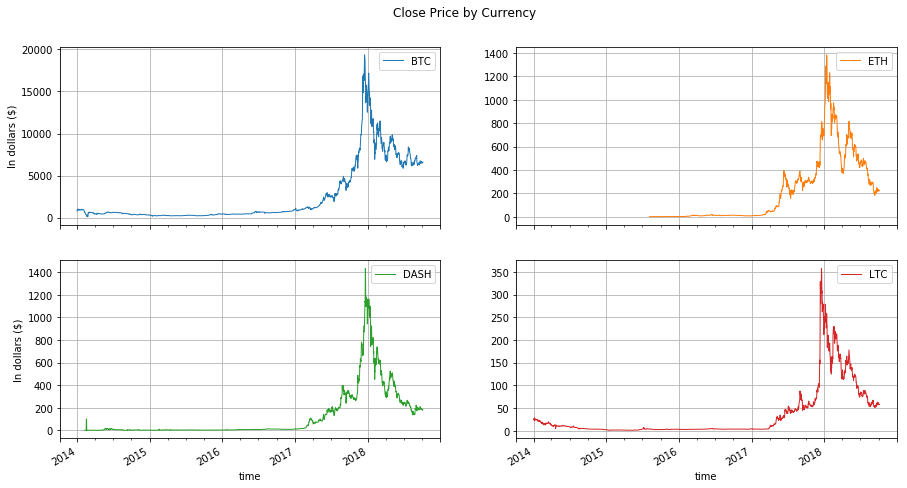

In [38]:
# plot price series
kw = dict(figsize=(15,8), grid=True, subplots=True, layout=(2,2), linewidth=1)
axs = prices.plot(**kw)
[ax.set_ylabel('In dollars ($)') for ax in axs.flat[::2]]
plt.suptitle('Close Price by Currency', y=0.95);

In [39]:
# table hurst with entire series
hurst_methods = [
    prices.apply(lambda x: hurst_exponent(x.dropna(), method='DSOD')),
    prices.apply(lambda x: hurst_exponent(x.dropna(), method='RS')),
    prices.apply(lambda x: hurst_exponent(x.dropna(), method='DMA')),
]
hurst_table = pd.concat(hurst_methods, axis=1)
hurst_table.columns = ['DSOD', 'RS', 'DMA']
hurst_table

/Users/robert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:303: RuntimeWarning: invalid value encountered in hurst_rs
/Users/robert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:189: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


,DSOD,RS,DMA
BTC,0.577499,0.584773,0.480461
ETH,0.568257,0.625567,0.478426
DASH,0.457155,0.536140,0.514339
LTC,0.566979,0.587441,0.411997


In [40]:
# the same methodology as shown in the paper.
roll_days = 200
roll_prices = prices.rolling(roll_days)
summary = [
    roll_prices.apply(lambda s: hurst_exponent(s, method='RS')),
    roll_prices.apply(lambda s: hurst_exponent(s, method='DSOD')),
    ]
roll_hurst = pd.concat(summary, axis=1, keys=['RS', 'DSOD'])
roll_hurst = roll_hurst.swaplevel(axis=1)\
                       .asfreq(roll_hurst.index.inferred_freq)\
                       .sort_index(axis=1, level=0)

/Users/robert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """
/Users/robert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  


In [41]:
roll_hurst[::10].tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2018-08-18  0.347745  0.515184  0.325763  0.478569  0.263323  0.581045   
2018-08-28  0.301987  0.496254  0.205628  0.552667  0.266612  0.627432   
2018-09-07  0.363679  0.520800  0.361300  0.602948  0.299439  0.643739   
2018-09-17  0.373921  0.542510  0.380911  0.590935  0.328572  0.652428   
2018-09-27  0.362799  0.533497  0.309405  0.596862  0.329529  0.662638   

                 LTC            
                DSOD        RS  
time                            
2018-08-18  0.354310  0.479552  
2018-08-28  0.359619  0.475433  
2018-09-07  0.266157  0.558313  
2018-09-17  0.286497  0.587041  
2018-09-27  0.302716  0.595715

In [42]:
roll_hurst[::20].tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2018-06-29  0.401680  0.547935  0.445986  0.561925  0.554858  0.642802   
2018-07-19  0.460709  0.595767  0.463613  0.540160  0.559434  0.608572   
2018-08-08  0.364726  0.551387  0.324427  0.524018  0.335357  0.585666   
2018-08-28  0.301987  0.496254  0.205628  0.552667  0.266612  0.627432   
2018-09-17  0.373921  0.542510  0.380911  0.590935  0.328572  0.652428   

                 LTC            
                DSOD        RS  
time                            
2018-06-29  0.395587  0.483151  
2018-07-19  0.485171  0.467979  
2018-08-08  0.426897  0.493060  
2018-08-28  0.359619  0.475433  
2018-09-17  0.286497  0.587041

In [43]:
roll_hurst[::30].tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2018-05-10  0.600371  0.629941  0.458410  0.659188  0.607463  0.627727   
2018-06-09  0.599531  0.607781  0.476753  0.631434  0.601342  0.646412   
2018-07-09  0.380213  0.566929  0.429036  0.500866  0.559017  0.631351   
2018-08-08  0.364726  0.551387  0.324427  0.524018  0.335357  0.585666   
2018-09-07  0.363679  0.520800  0.361300  0.602948  0.299439  0.643739   

                 LTC            
                DSOD        RS  
time                            
2018-05-10  0.588529  0.576954  
2018-06-09  0.587474  0.588615  
2018-07-09  0.455528  0.462890  
2018-08-08  0.426897  0.493060  
2018-09-07  0.266157  0.558313

In [44]:
roll_hurst[::50].tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2018-02-09  0.659344  0.645741  0.474542  0.645617  0.676694  0.593281   
2018-03-31  0.613790  0.649037  0.466400  0.643798  0.629405  0.594054   
2018-05-20  0.603245  0.627348  0.460886  0.668089  0.610988  0.654670   
2018-07-09  0.380213  0.566929  0.429036  0.500866  0.559017  0.631351   
2018-08-28  0.301987  0.496254  0.205628  0.552667  0.266612  0.627432   

                 LTC            
                DSOD        RS  
time                            
2018-02-09  0.617152  0.614079  
2018-03-31  0.597977  0.595393  
2018-05-20  0.588848  0.599734  
2018-07-09  0.455528  0.462890  
2018-08-28  0.359619  0.475433

In [45]:
roll_hurst[::10].mean()

BTC   DSOD    0.553235
      RS      0.568829
DASH  DSOD    0.332152
      RS      0.501510
ETH   DSOD    0.512472
      RS      0.606659
LTC   DSOD    0.544093
      RS      0.536474
dtype: float64

In [46]:
roll_hurst[::20].mean()

BTC   DSOD    0.550102
      RS      0.569688
DASH  DSOD    0.334667
      RS      0.502337
ETH   DSOD    0.505291
      RS      0.607335
LTC   DSOD    0.537799
      RS      0.537953
dtype: float64

In [47]:
roll_hurst[::30].mean()

BTC   DSOD    0.560302
      RS      0.568443
DASH  DSOD    0.344915
      RS      0.503285
ETH   DSOD    0.510997
      RS      0.605154
LTC   DSOD    0.533686
      RS      0.536863
dtype: float64

In [48]:
roll_hurst[::50].mean()

BTC   DSOD    0.549255
      RS      0.565762
DASH  DSOD    0.324997
      RS      0.499656
ETH   DSOD    0.536697
      RS      0.601862
LTC   DSOD    0.541610
      RS      0.536558
dtype: float64

In [49]:
roll_hurst[::10].median()

BTC   DSOD    0.569754
      RS      0.575027
DASH  DSOD    0.379382
      RS      0.516328
ETH   DSOD    0.524698
      RS      0.618018
LTC   DSOD    0.594761
      RS      0.545767
dtype: float64

In [50]:
roll_hurst[::20].median()

BTC   DSOD    0.574950
      RS      0.572908
DASH  DSOD    0.386702
      RS      0.521680
ETH   DSOD    0.518820
      RS      0.618018
LTC   DSOD    0.588848
      RS      0.549933
dtype: float64

In [51]:
roll_hurst[::30].median()

BTC   DSOD    0.557265
      RS      0.566929
DASH  DSOD    0.393447
      RS      0.518617
ETH   DSOD    0.525679
      RS      0.622150
LTC   DSOD    0.594789
      RS      0.543010
dtype: float64

In [52]:
roll_hurst[::50].median()

BTC   DSOD    0.575757
      RS      0.566929
DASH  DSOD    0.351925
      RS      0.507125
ETH   DSOD    0.551380
      RS      0.618018
LTC   DSOD    0.597977
      RS      0.532983
dtype: float64

In [53]:
roll_hurst[::10].mean(level=0, axis=1);

In [54]:
roll_hurst[::20].mean(level=0, axis=1);

In [55]:
roll_hurst[::30].mean(level=0, axis=1);

In [56]:
roll_hurst[::50].mean(level=0, axis=1);

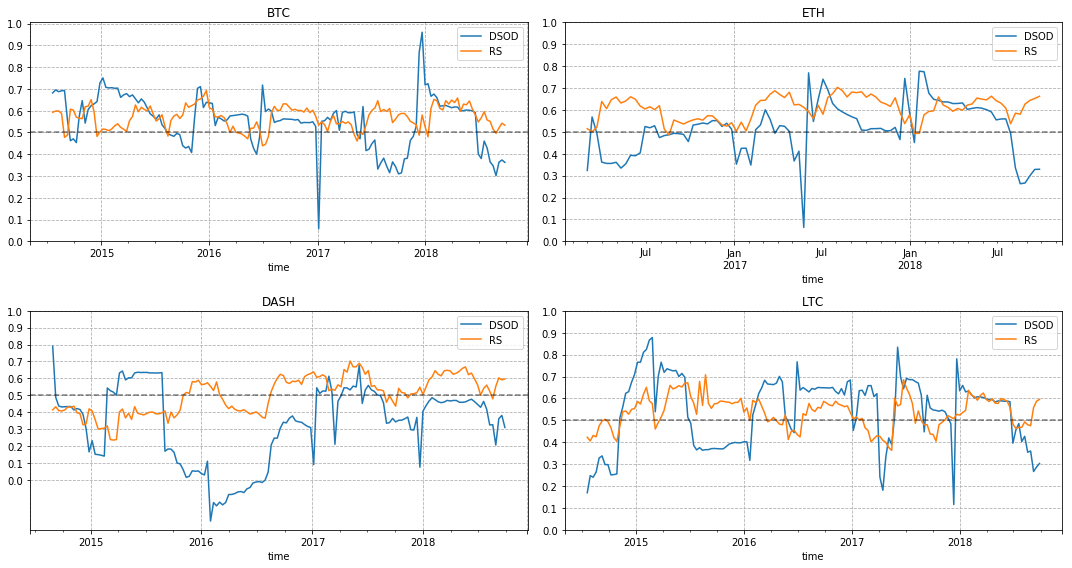

In [57]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::10].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

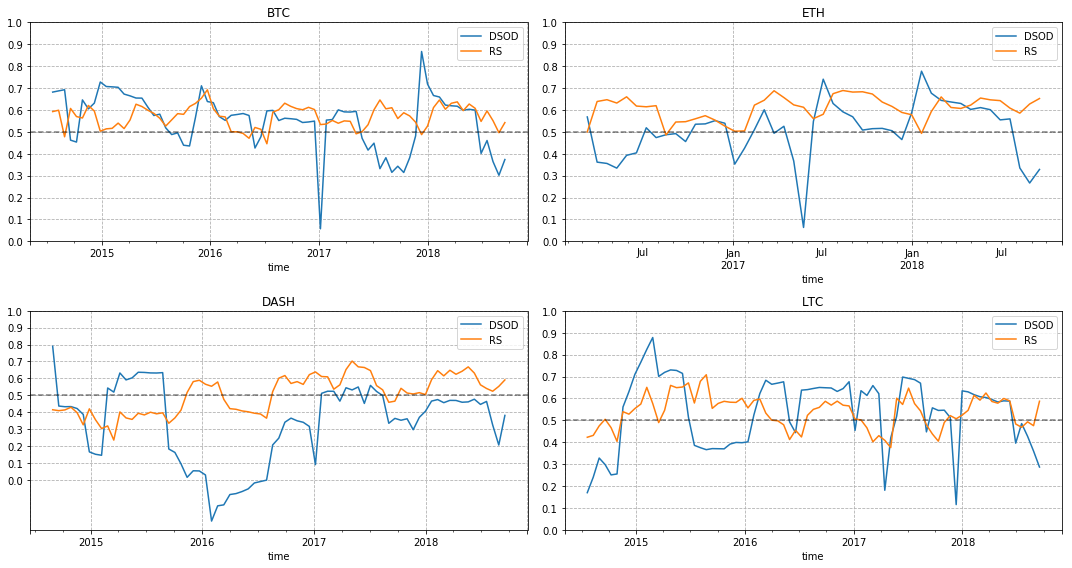

In [58]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::20].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

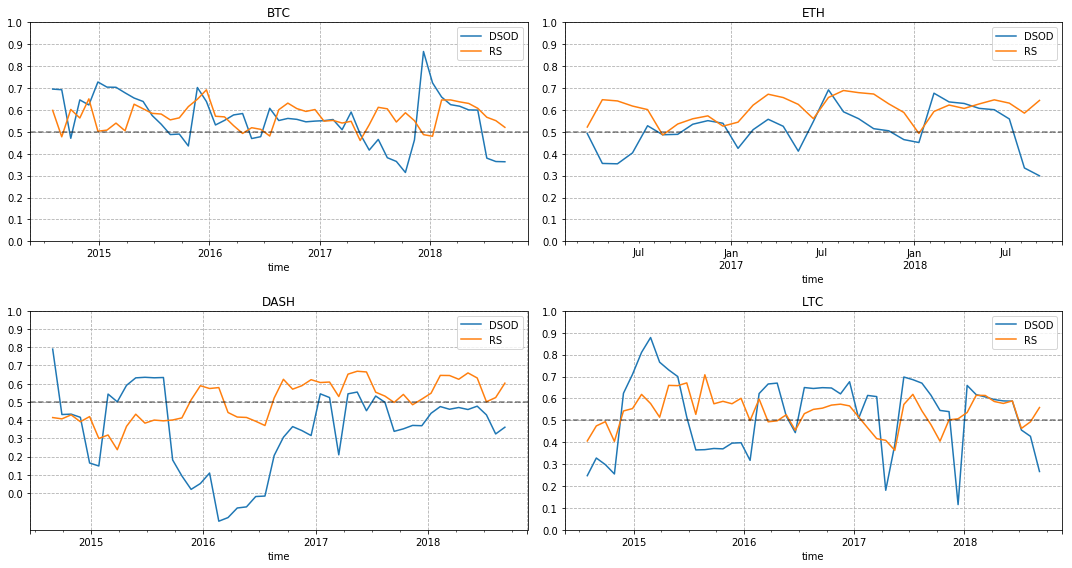

In [59]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::30].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

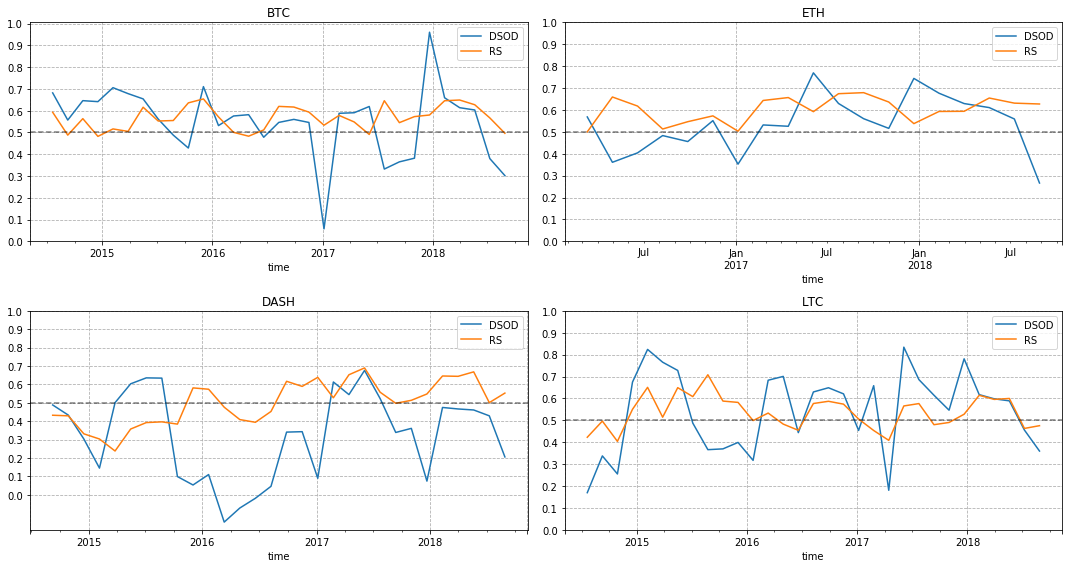

In [60]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin][::50].plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

In [61]:
# rather decimate the series we aliasing the seies.
ma_roll_hurst = roll_hurst.rolling(10).mean()
ma_roll_hurst.tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2018-10-01  0.356118  0.539187  0.313548  0.604505  0.327548  0.661359   
2018-10-02  0.361192  0.537080  0.313786  0.604172  0.330487  0.660386   
2018-10-03  0.365471  0.535684  0.312760  0.602846  0.331750  0.659659   
2018-10-04  0.367110  0.534540  0.311385  0.601907  0.331125  0.659206   
2018-10-05  0.368064  0.536276  0.309954  0.601644  0.331291  0.659100   

                 LTC            
                DSOD        RS  
time                            
2018-10-01  0.297403  0.591377  
2018-10-02  0.301486  0.592089  
2018-10-03  0.301495  0.593157  
2018-10-04  0.300118  0.593179  
2018-10-05  0.297374  0.594108

In [62]:
# rather decimate the series we aliasing the seies.
ma_roll_hurst = roll_hurst.rolling(20).mean()
ma_roll_hurst.tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2018-10-01  0.360554  0.550609  0.335671  0.599865  0.323233  0.659932   
2018-10-02  0.360484  0.549235  0.333161  0.601016  0.323435  0.660089   
2018-10-03  0.359793  0.548045  0.330598  0.600797  0.323515  0.659174   
2018-10-04  0.358432  0.547005  0.326925  0.601093  0.323361  0.658910   
2018-10-05  0.356911  0.545839  0.322649  0.601072  0.323172  0.659015   

                 LTC            
                DSOD        RS  
time                            
2018-10-01  0.286574  0.586355  
2018-10-02  0.286509  0.587077  
2018-10-03  0.286534  0.587198  
2018-10-04  0.285571  0.588328  
2018-10-05  0.284832  0.589930

In [63]:
# rather decimate the series we aliasing the seies.
ma_roll_hurst = roll_hurst.rolling(30).mean()
ma_roll_hurst.tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2018-10-01  0.366063  0.543068  0.338712  0.597055  0.322380  0.656896   
2018-10-02  0.366948  0.543574  0.340440  0.597253  0.323491  0.656945   
2018-10-03  0.366054  0.544042  0.340208  0.597509  0.323782  0.656746   
2018-10-04  0.364116  0.544994  0.338778  0.597717  0.323624  0.656614   
2018-10-05  0.364047  0.545777  0.336760  0.597902  0.323221  0.656383   

                 LTC            
                DSOD        RS  
time                            
2018-10-01  0.300464  0.574558  
2018-10-02  0.297675  0.575929  
2018-10-03  0.294602  0.577043  
2018-10-04  0.290830  0.578661  
2018-10-05  0.289747  0.580447

In [64]:
# rather decimate the series we aliasing the seies.
ma_roll_hurst = roll_hurst.rolling(50).mean()
ma_roll_hurst.tail()

BTC                DASH                 ETH            \
                DSOD        RS      DSOD        RS      DSOD        RS   
time                                                                     
2018-10-01  0.344327  0.537794  0.304043  0.577412  0.299079  0.635803   
2018-10-02  0.345527  0.537449  0.304913  0.578878  0.301338  0.637313   
2018-10-03  0.346384  0.536395  0.305252  0.579976  0.302945  0.638772   
2018-10-04  0.347257  0.535571  0.305679  0.580942  0.304799  0.639864   
2018-10-05  0.347782  0.535300  0.305542  0.582397  0.306347  0.641040   

                 LTC            
                DSOD        RS  
time                            
2018-10-01  0.333603  0.542437  
2018-10-02  0.331598  0.544612  
2018-10-03  0.328995  0.546565  
2018-10-04  0.326423  0.548286  
2018-10-05  0.323858  0.550350

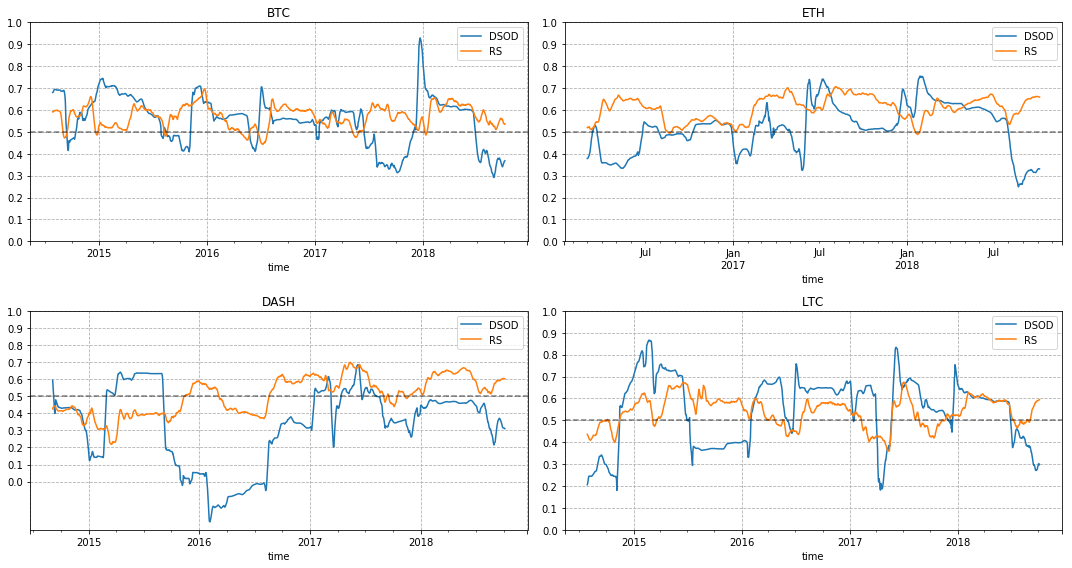

In [65]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(10).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

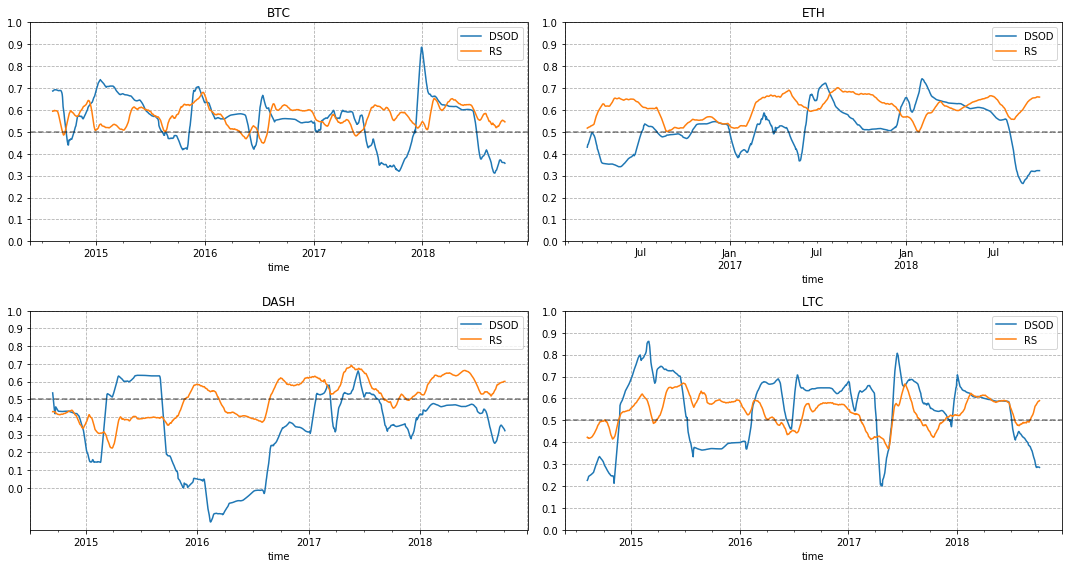

In [66]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(20).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

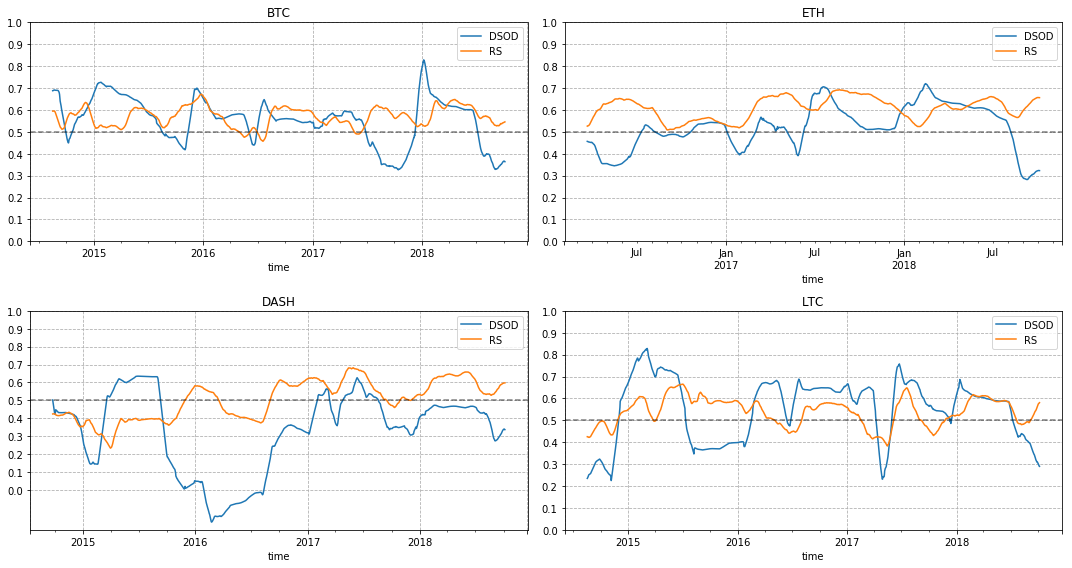

In [67]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(30).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

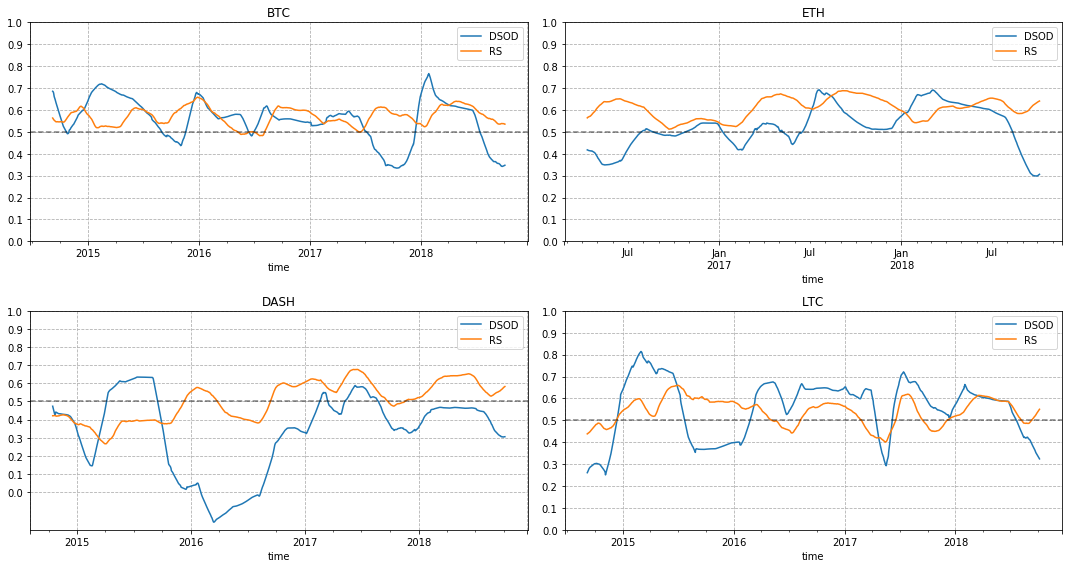

In [68]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
for ax, coin in zip(axs.flat, coin_sym_list):
    roll_hurst[coin].rolling(50).mean().plot(ax=ax)
    ax.set_title(coin)
    ax.set_yticks(np.arange(11)/10)
    ax.grid(True, linestyle='--')
    ax.axhline(0.5, linestyle='--', color='k', alpha=0.5)
fig.tight_layout()

# REFERENCES

- Caporale, G. M., Gil-Alana, L., & Plastun, A. (2017). Persistence in the Cryptocurrency Market. https://www.sciencedirect.com/science/article/pii/S0275531917309200
- H.E. Hurst, 1951, “Long-term storage of reservoirs: an experimental study,” Transactions of the American Society of Civil Engineers, Vol. 116, pp. 770-799.
- Bo Qian, Khaled Rasheed, 2004, “Hurst Exponent and financial market predictability,” IASTED conference on “Financial Engineering and Applications”(FEA 2004), pp. 203-209,
- Mandelbrot, Benoit B., 2004, “The (Mis)Behavior of Markets, A Fractal View of Risk, Ruin and Reward,” Basic Books, 2004.
